# 0. AMEX Default Prediction

Key points:

1. The data is anonymized and has been artificially noised. Start with the [parquet data by Raddar](https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format/data). 
2. The classes are imbalanced. A StratifiedKFold for cross-validation is recommended. Also, since the last statement date is the same for all customers, we cannot use TimeSeriesSplit.
3. Some missing values are systematic, and related to the statement date or the target. We can learn more in depth about it from [Raddar's notebook0(https://www.kaggle.com/code/raddar/understanding-na-values-in-amex-competition). 
4. D_39 is actually an imperative feature, days_overdue, which is essentially equivalent to the target. Delete it if you don't wanna leak the target. Details are [here](https://www.kaggle.com/code/raddar/deanonymized-days-overdue-feat-amex).
5. There are a few other redundant features according to [this](https://www.kaggle.com/competitions/amex-default-prediction/discussion/338569) and [that](https://www.kaggle.com/code/raddar/redundant-features-amex/notebook).
6. The data has a temporal structure - each customer has N months of history observed (N = 1,...,13). We choose to use the N=13 customers ONLY for simplicity.
7. Given the innate temporal structure of the data, we should consider doing feature engineering of aggregating over each customer like the following:
    - rolling averages, std, min, max for the numeric features
    - rolling counts and nuniques for the categorical features
    - First occurrence
    - Last occurrence
    - Last_diff_First: the change since we first see the customer to the last time we see the customer
    - Last/First: the fractional difference from the first to the last occurrence


# 1. Module Management and Data Import

In [239]:
# data manipulation
import os
import pandas as pd
import numpy as np
import scipy as sp
# syntax encoding
import datetime
import pickle, gc
pd.options.mode.copy_on_write = True # computation
import joblib  # a tool to provide lightweight pipelining in Python. 1. easy simple parallel computing, 2. transparent disk-caching of functions and lazy re-evaluation
from tqdm import tqdm   # a fast, extensible progress bar for loops and CLI
import copy   # shallow and deep copy operations
from sklearn.base import clone

In [240]:
# modeling
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import pipeline
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, confusion_matrix, classification_report

In [241]:
# visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import july

In [242]:
# Aesthetics
import gc
import warnings
sns.set_style("ticks")
sns.color_palette("husl", 8)
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 10
pd.options.display.max_columns = 25
pd.options.display.max_rows = 30
pd.options.display.float_format = '{:.2f}'.format
!python --version

Python 3.9.19


## 1.2 The data import
The dataset of this competition has a considerable size. If you read the original csv files, the data barely fits into memory. Thus, we choose to work with a dataset that has reduced data precision.

Meanwhile, as it is discussed in [here by @RADDAR](https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514), all float type columns have a uniform noise of Unif[0, 0.01] added to them as the artificial noise by AMEX as a safety measure to further de-anonymize them. The details are like this. The original 190 features have 1 'customer_ID', 1 'S_2' in the datetime type, 95 in the np.int8/np.int16 types, 93 in the np.float32 types. Most float columns with [0, 0.01] and [1, 1.01] have these values rounded up at 0 and 1 respectively. This was done to ensure no data loss, as not all features could be rounded up safe. As a result, the data gets shrinked in size after the noise removel as some previous float data become integers in {0, 1}.  

Based on the above two points, we decide to use the data from [@RADDAR](https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format/data). In this Parquet file, the floating point precision has been reduced from 64 bit to 32 bit, then a removal of the artificially added noise further converted some float columns to integers. 

- There are 5.5 million rows for train and 11 million rows of test data. The 'customer_ID' has no duplicates. Both of them have 190 features. The train data takes **2.72** GBytes of RAM. The test data is **twice the size** of the train data.
- The train statement dates range from 2017-03-01 to 2018-03-31.
- The test statement dates range from 2018-04-01 to 2019-10-31.
- The y_train or the target label for all customers is null free.

**Insight**:

    - Given the sheer size of datasets, memory efficiency and copy parsimony is imperative. 
    - Although the entire train data needs to be feed to the ML algorithms, we can make the predictions in batch, meaning batch processing on the test.
    - We don't have to load the test until the models have been trained and tuned. 
    - The customer_ID is in hex coding. Remove the first 16 byts and convert the rest to decimal integers.
    - (To do) Using Cudf to speed up pandas

In [243]:
# FILL NAN VALUE
NAN_VALUE = -127 # will fit in int8

y_train = pd.read_csv('data/train_labels.csv')
# Reduce the DTYPE of customer_ID
y_train['customer_ID'] = y_train['customer_ID'].str[-16:].apply(lambda x: int(x, 16)).astype(np.int64).astype('category')

X_train = pd.read_parquet('data/train.parquet')
# Reduce the DTYPE of customer_ID AND S_2 convert to date 
X_train['customer_ID'] = X_train['customer_ID'].str[-16:].apply(lambda x: int(x, 16)).astype(np.int64).astype('category')
X_train['S_2'] = pd.to_datetime(X_train['S_2'])
# Fill NaN values
# X_train.fillna(NAN_VALUE, inplace=True)

with pd.option_context("display.min_rows", 4):
    display(X_train)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,-4532153018459703766,2017-03-09,0.94,0,0.01,1.01,0.01,0.12,0.00,0.00,NaN,NaN,...,NaN,-1,-1,-1,-1,0,0,0.00,NaN,0,0.00,0
1,-4532153018459703766,2017-04-07,0.94,0,0.00,1.00,0.01,0.13,0.00,0.00,NaN,NaN,...,NaN,-1,-1,-1,-1,0,0,0.00,NaN,0,0.01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531449,-8425848485496994175,2018-02-06,0.97,15,0.01,1.00,0.01,0.10,0.00,0.01,NaN,0.01,...,NaN,-1,-1,-1,-1,0,0,0.00,NaN,0,0.00,0
5531450,-8425848485496994175,2018-03-14,0.98,0,0.00,0.99,0.00,0.12,0.00,0.01,NaN,0.01,...,NaN,-1,-1,-1,-1,0,0,0.00,NaN,0,0.00,0


In [244]:
# merge the y_train and X_train as train for EDA purpose
train = X_train.merge(y_train, left_on='customer_ID', right_on='customer_ID')

In [245]:
X_test = pd.read_parquet('data/test.parquet')
# REDUCE DTYPE FOR CUSTOMER AND DATE
X_test['customer_ID'] = X_test['customer_ID'].str[-16:].apply(lambda x: int(x, 16)).astype(np.int64).astype('category')
X_test['S_2'] = pd.to_datetime(X_test['S_2'])
# Fill NaN values
# X_test.fillna(NAN_VALUE, inplace=True)

with pd.option_context("display.min_rows", 4):
    display(X_test)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,8717704911770597815,2019-02-19,0.63,0,0.01,0.81,0.00,0.17,0.00,0.00,0.11,NaN,...,NaN,-1,-1,-1,-1,-1,0,NaN,NaN,-1,0.01,-1
1,8717704911770597815,2019-03-25,0.59,0,0.01,0.81,0.00,0.24,0.00,0.01,0.12,NaN,...,NaN,-1,-1,-1,-1,0,0,0.00,NaN,0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11363760,-1477111782539041971,2019-03-19,0.46,0,0.01,0.82,0.00,NaN,0.00,0.01,0.11,NaN,...,NaN,-1,-1,-1,-1,0,0,0.00,NaN,0,0.01,0
11363761,-1477111782539041971,2019-04-18,0.45,0,0.00,0.81,0.00,NaN,0.00,0.00,0.11,NaN,...,NaN,-1,-1,-1,-1,0,0,0.00,NaN,0,0.01,0


In [246]:
print(f'Train data memory usage: {X_train.memory_usage().sum() / 1e9} GBytes')
print(f'Test data memory usage:  {X_test.memory_usage().sum() / 1e9} GBytes')

Train data memory usage: 2.719927848 GBytes
Test data memory usage:  5.59809333 GBytes


In [247]:
print(f'The train statement dates range from {X_train.S_2.min()} to {X_train.S_2.max()}.')
print(f'The test statement dates range from {X_test.S_2.min()} to {X_test.S_2.max()}')

The train statement dates range from 2017-03-01 00:00:00 to 2018-03-31 00:00:00.
The test statement dates range from 2018-04-01 00:00:00 to 2019-10-31 00:00:00


# 2. EDA
Columns in the dataset are divided by the organisers in the following groups:
- D_*: Delinquency variables
- S_*: Spend variables
- P_*: Payment variables
- B_*: Balance variables
- R_*: Risk variables
Following features are categorical: B_30, B_38, D_63, D_64, D_66, D_68, D_114, D_116, D_117, D_120, D_126.

S_2: contains a timestamp

## 2.1 The target label

In the train, we have 458,913 unique customer_IDs, among which 340,000 (74.1 %) have a label of 0 (never defaulted) and 119,000 (25.9 %) have a label of 1 (defaulted).
In addition, we know that the good customers have been sub-sampled by a factor of 20; this means that in reality there are 6.8 million good customers. Hence, in the original population, 98.3% of the customers are 0; 1.7% are 1.
Furthermore, we verify that the proportion of the target label is roughly consistent across each day in the time period of the train.
Finally, **the label is for the last statement for each customer ONLY, not cumulative. It actually signals whether the customer pay due amount in 120 days after his/her latest statement.**

**Insight**:

    - The classes are 3:1, hence it is not necessary to do stratified split or adjust using class weights.  
    - Due to the imbalance, in addition to the competition specific metric, AUC of the ROC and f1-score could be used as auxillary metrics.

In [248]:
label_stats = pd.DataFrame({'Count': y_train.target.value_counts(),
              '%': y_train.target.value_counts() / len(y_train)})
label_stats['Count in population'] =  label_stats['Count'] * np.array([20, 1])
label_stats['% in population'] = label_stats['Count in population'] / label_stats['Count in population'].sum()
label_stats

,Count,%,Count in population,% in population
target,,,,
0,340085,0.74,6801700,0.98
1,118828,0.26,118828,0.02


## 2.2  The time presence of customers

We'd like to know how many rows (credit card statements) each customer has and their distributions. The results is that 80% of the customers have 13 statements; the other 20% of the customers have between 1 and 12 statements.

DO this part's visulization by https://www.kaggle.com/code/datark1/american-express-eda/notebook!!!!!!!!!

**Insight**:

    - The data has a temporal structure - each customer has N months of history observed (N = 1,...,13). 
    - Our model needs to able to deal with a variable observed history record lengths (N) per customer. A good way to pull it through is via adding new customer-level historical aggregated features in the later parts. 
    - Optionally, we could choose to use the N=13 customers ONLY for simplicity.  

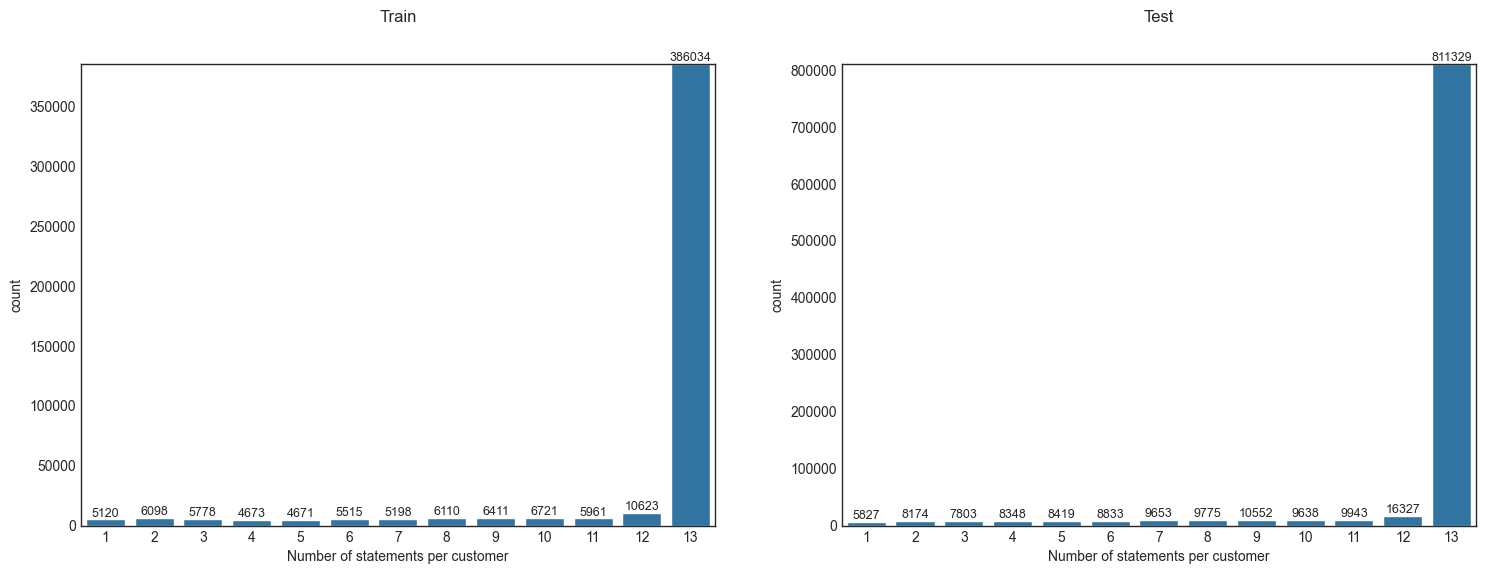

In [249]:
# plot the number of statements per customer as barplots in the train and test data
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(X_train.customer_ID.value_counts().value_counts().sort_index(ascending=False), ax=ax[0])
ax[0].bar_label(ax[0].containers[0], fmt='%.0f', label_type='edge', fontsize=9)
ax[0].set_xlabel('Number of statements per customer')
ax[0].set_title('Train')
sns.barplot(X_test.customer_ID.value_counts().value_counts().sort_index(ascending=False), ax=ax[1])
ax[1].bar_label(ax[1].containers[0], fmt='%.0f', label_type='edge', fontsize=9)
ax[1].set_xlabel('Number of statements per customer')
ax[1].set_title('Test')
plt.show()

Let's find out when these customers got their last statement. The histogram of the last statement dates shows that every train customer got his last statement in March of 2018. The first four Saturdays (March 3, 10, 17, 24) have more statements than an average day.

The test customers are split in two: half of them got their last statement in April of 2019 and half in October of 2019. As was discussed here, the April 2019 data is used for the public leaderboard and the October 2019 data is used for the private leaderboard.

Although the data are a kind of time series, we cannot cross-validate with a TimeSeriesSplit because all training happens in the same month.

For most customers, the first and last statement is about a year apart. Together with the fact that we typically have 13 statements per customer, this indicates that the customers get one credit card statement every month.

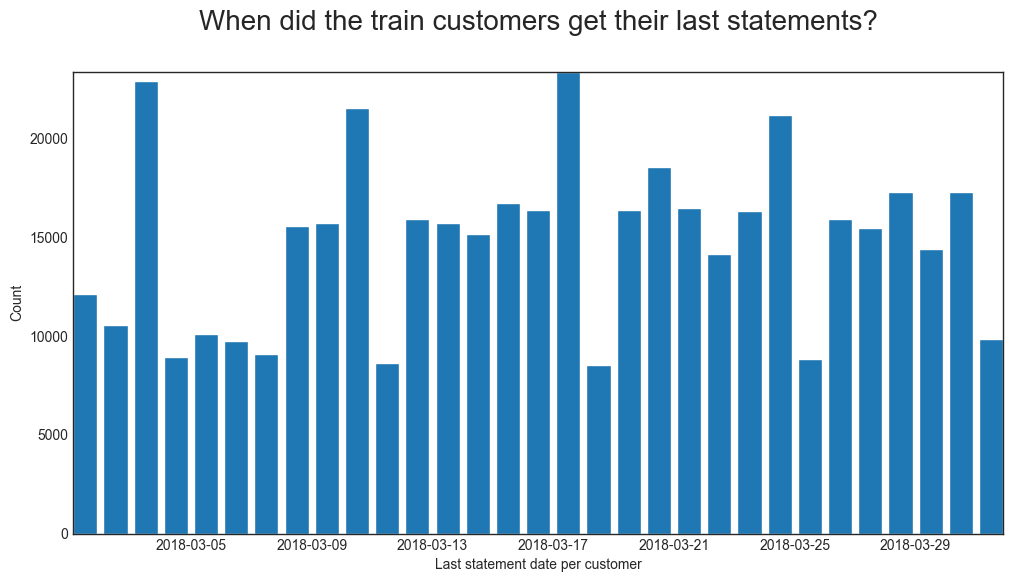

In [250]:
train_last_date = X_train.S_2.groupby(X_train.customer_ID, observed=False).max()
plt.hist(train_last_date, bins=pd.date_range("2018-03-01", "2018-04-01", freq="d"),
         rwidth=0.8)
plt.title('When did the train customers get their last statements?', fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Count')
plt.show()
del train_last_date

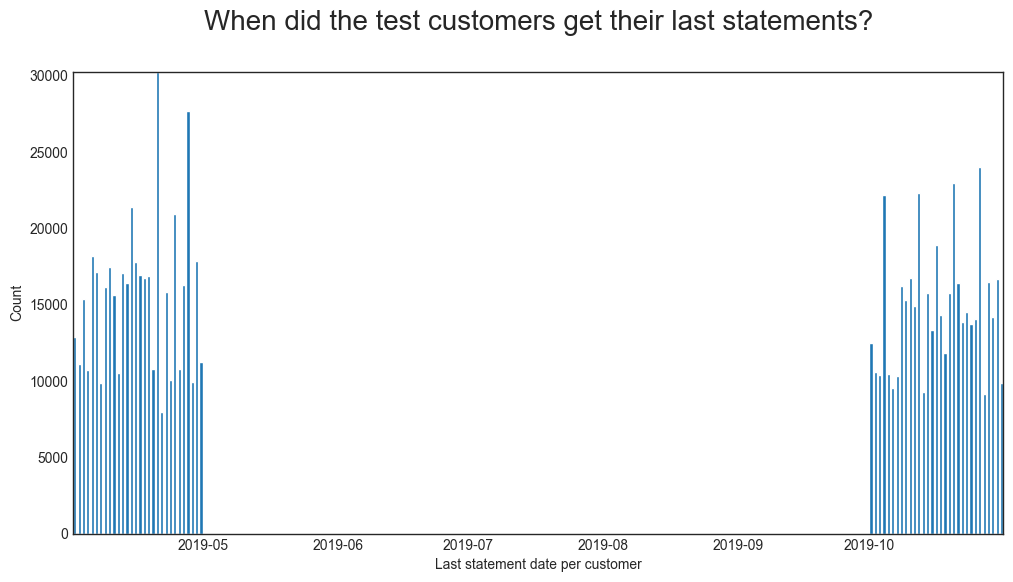

In [251]:
test_last_date = X_test.S_2.groupby(X_test.customer_ID, observed=False).max()
plt.hist(test_last_date, bins=pd.date_range("2019-04-01", "2019-11-01", freq="d"),
         rwidth=0.74)
plt.title('When did the test customers get their last statements?', fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Count')
plt.show()
del test_last_date

If we color every statement (i.e. row of train or test) according to the dataset it belongs (training, public lb, and private lb), we see that every dataset covers thirteen months. Train and test don't overlap, but public and private lb periods overlap.

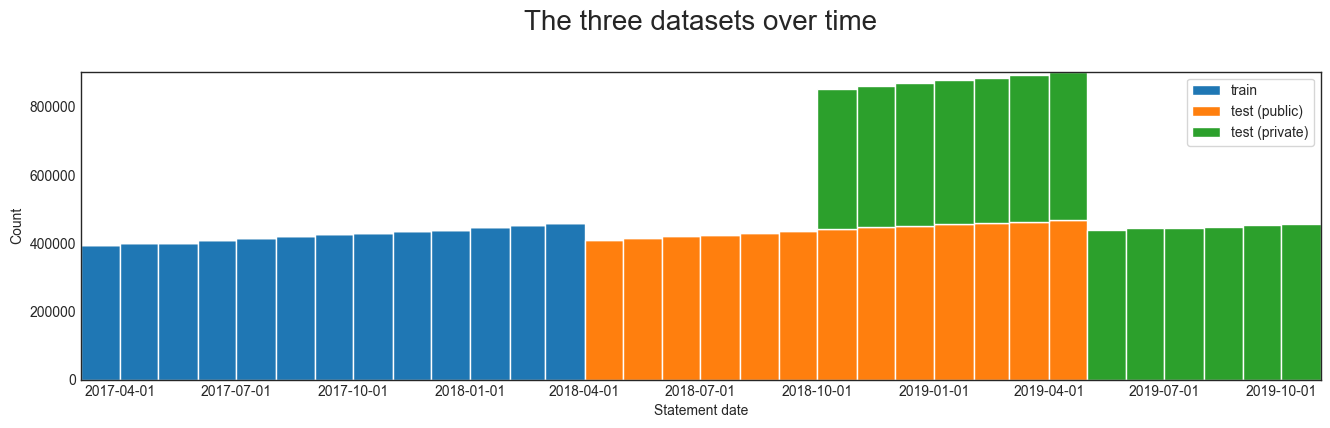

In [252]:
temp = pd.concat([X_train[['customer_ID', 'S_2']], X_test[['customer_ID', 'S_2']]], axis=0)
temp.set_index('customer_ID', inplace=True)

temp['last_month'] = temp.groupby('customer_ID', observed=False).S_2.max().dt.month
last_month = temp['last_month'].values


plt.figure(figsize=(16, 4))
plt.hist([temp.S_2[temp.last_month == 3],   # ending 03/18 -> training
          temp.S_2[temp.last_month == 4],   # ending 04/19 -> public lb
          temp.S_2[temp.last_month == 10]], # ending 10/19 -> private lb
         bins=pd.date_range("2017-03-01", "2019-11-01", freq="MS"),
         label=['train', 'test (public)', 'test (private)'],
         stacked=True)
plt.xticks(pd.date_range("2017-03-01", "2019-11-01", freq="QS"))
plt.xlabel('Statement date')
plt.ylabel('Count')
plt.title('The three datasets over time', fontsize=20)
plt.legend()
plt.show()
del temp

## 2.3 'S_2' datetime stamp related distribution

We observed that Saturday seemed to be the most popular choice among the weekday of statement closing dates across train and test by a huge margin, while Sunday seemed to be the rarest choice. **Nevertheless, consistent higher than average default rates were recorded on Sundays in the train data.**

**Insight**:

    - Is it worthy to dig up why most customers have their statement closing dates on Saturdays, albeit AMEX has restrictions on how often their customers can request to change the statement closing dates?
    - Is it worthy to add a weekday feature during the ensuing feature engineering given we saw the pattern between Sunday and default rate? 

In [253]:
train_S2 = X_train[['customer_ID', 'S_2']].copy()
test_S2 = X_test[['customer_ID', 'S_2']].copy()

train_S2 = pd.merge(train_S2, y_train, on='customer_ID', how='left')


train_S2['N'] = train_S2.groupby('customer_ID', observed=False)['customer_ID'].transform('count')
test_S2['N'] = test_S2.groupby('customer_ID', observed=False)['customer_ID'].transform('count')

test_S2['max_data'] = test_S2.groupby('customer_ID', observed=False)['S_2'].transform('max')
test_S2_1 = test_S2.loc[test_S2['max_data'].apply(lambda t: t.month == 4)]
test_S2_2 = test_S2.loc[test_S2['max_data'].apply(lambda t: t.month == 10)]

tx = train_S2.groupby('S_2')['customer_ID'].count().reset_index(name='count')
ty = train_S2.groupby('S_2')['target'].mean().reset_index(name='target rate')
tw1 = test_S2_1.groupby('S_2')['customer_ID'].count().reset_index(name='count')
tw2 = test_S2_2.groupby('S_2')['customer_ID'].count().reset_index(name='count')

del train_S2, test_S2, test_S2_1, test_S2_2

<Axes: title={'center': 'test (private) count'}>

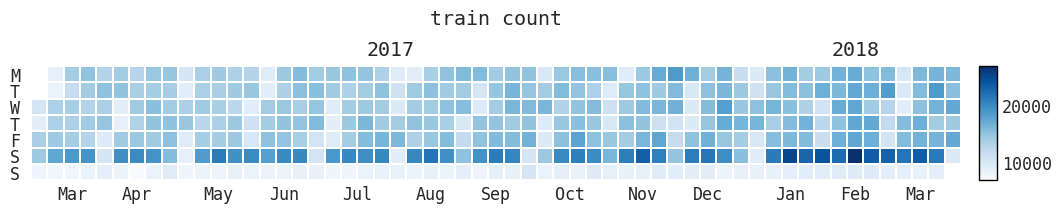

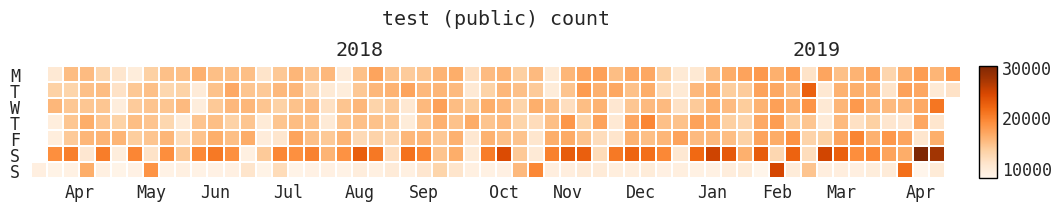

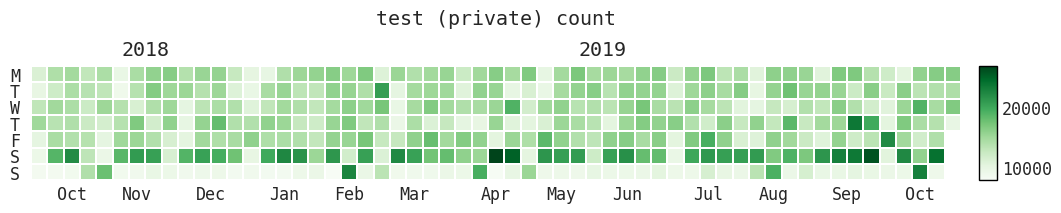

In [254]:
july.heatmap(tx['S_2'], tx['count'], title='train count', cmap="Blues", colorbar=True)
july.heatmap(tw1['S_2'], tw1['count'], title='test (public) count', cmap="Oranges", colorbar=True)
july.heatmap(tw2['S_2'], tw2['count'], title='test (private) count', cmap="Greens", colorbar=True)

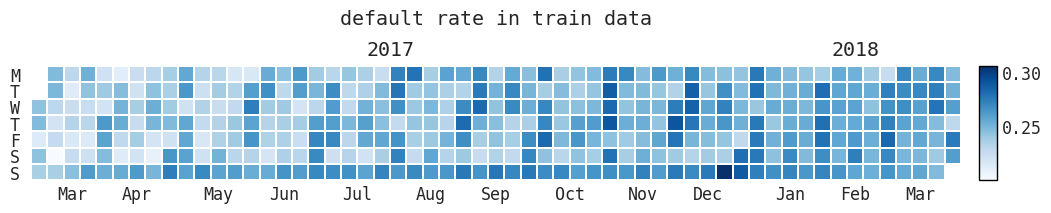

In [255]:
july.heatmap(ty['S_2'], ty['target rate'], title='default rate in train data', cmap="Blues", colorbar=True)
del tx, ty, tw1, tw2

In [256]:
# 'S_2' datetime stamp related distribution
target=pd.DataFrame(data={'Default':train.groupby('S_2')['target'].mean()*100})
target['Paid']=np.abs(train.groupby('S_2')['target'].mean()-1)*100
pal, color=['#016CC9','#DEB078'], ['#8DBAE2','#EDD3B3']
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.7)) for i in pal]
fig=go.Figure()
fig.add_trace(go.Bar(x=target.index, y=target.Paid, name='Paid',
                     text=target.Paid, texttemplate='%{text:.0f}%', 
                     textposition='inside',insidetextanchor="middle",
                     marker=dict(color=color[0],line=dict(color=pal[0],width=1.5)),
                     hovertemplate = "<b>%{x}</b><br>Paid accounts: %{y:.2f}%"))
fig.add_trace(go.Bar(x=target.index, y=target.Default, name='Default',
                     text=target.Default, texttemplate='%{text:.0f}%', 
                     textposition='inside',insidetextanchor="middle",
                     marker=dict(color=color[1],line=dict(color=pal[1],width=1.5)),
                     hovertemplate = "<b>%{x}</b><br>Default accounts: %{y:.2f}%"))
fig.update_layout(template=temp,title='default rate in train data', 
                  barmode='relative', yaxis_ticksuffix='%', width=1400,
                  legend=dict(orientation="h", traceorder="reversed", yanchor="bottom",y=1.1,xanchor="left", x=0))
fig.show()

## 2.4 The categorical features

According to the data description, there are 13 categorical features, 11 multilevel ones, 'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68', and 2 binary ones 'B_31', 'D_87'. We barplot them for fraud and non-fraud. For the ten features which have missing values, the missing values are represented by the rightmost bar of the histogram.


**Insight:**

    - All 13 categorical features are NA-free. 
    - All 13 categorical features have below 8 as their cardinalities. Thus, we can use one-hot encoding safely.

In [257]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68', 'B_31', 'D_87']
train[cat_features].isna().sum()

B_30     0
B_38     0
D_114    0
D_116    0
D_117    0
D_120    0
D_126    0
D_63     0
D_64     0
D_66     0
D_68     0
B_31     0
D_87     0
dtype: int64

In [258]:
def plot_cate_by_label_rate(fea, df, rotate=0, order_use=None, hue_label='target', title=None, fontsize=8):
    if order_use is None:
        order_use = df[fea].value_counts(ascending=False).index
    
    # Create the countplot
    ax = sns.countplot(x=fea, data=df, order=order_use, hue=hue_label, palette='coolwarm', dodge=True)
    
    # Calculate absolute and relative values
    abs_values = df[fea].value_counts(ascending=False)
    rel_values = df.groupby(fea)[hue_label].mean().loc[df[fea].value_counts(ascending=False).index]
    lbls = [f'{a:,} \n ({b:.2%})' for a, b in zip(abs_values, rel_values)]
    
    # Rotate x-axis labels
    for label in ax.get_xticklabels():
        label.set_rotation(rotate)
    
    # Set the title
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title(f'[{fea}] distribution by {hue_label} rate')
    
    # Add bar labels on top of the bars and please specify the container!!!!!!!!
    if any(lbls) is not None:
        ax.bar_label(container=ax.containers[1], labels=lbls, fontsize=fontsize, padding=3)
    
    # Set y-axis label
    ax.set_ylabel('Count')
    
    # Set x-axis label
    plt.xlabel(fea)
    
    # Handle binary features
    if df[fea].nunique() == 2:
        plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
    
    # Move legend
    sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1), labels=['Paid', 'Default'], title=None, fontsize=fontsize)
    
    # Show the plot
    plt.show()

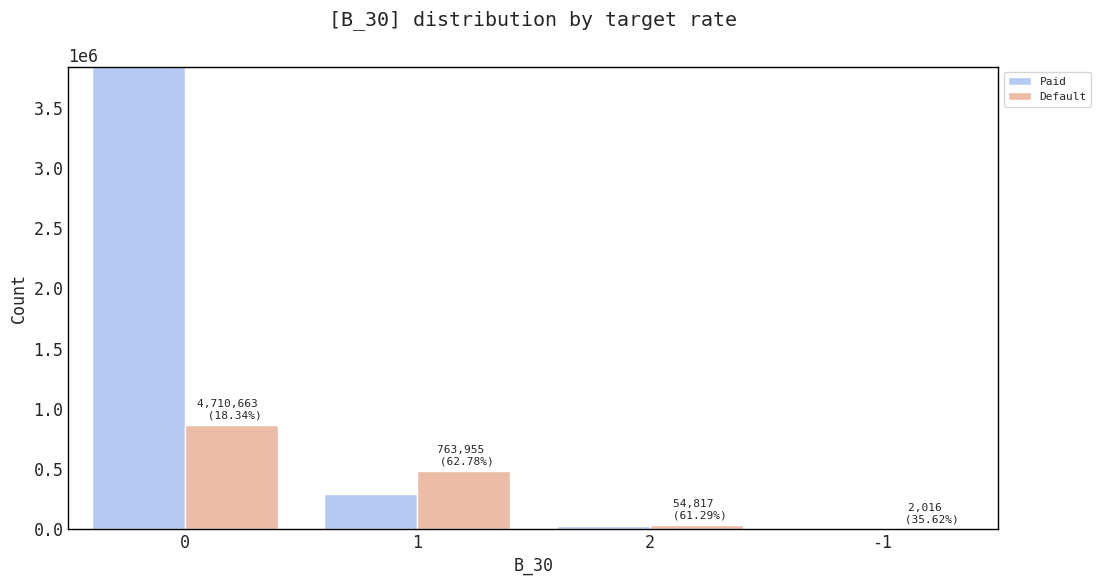

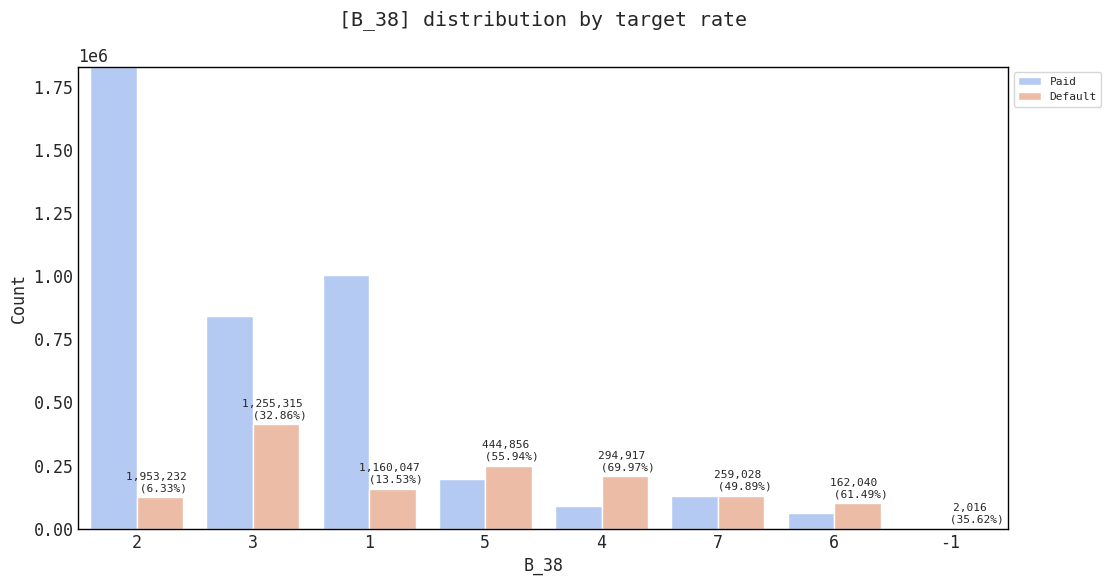

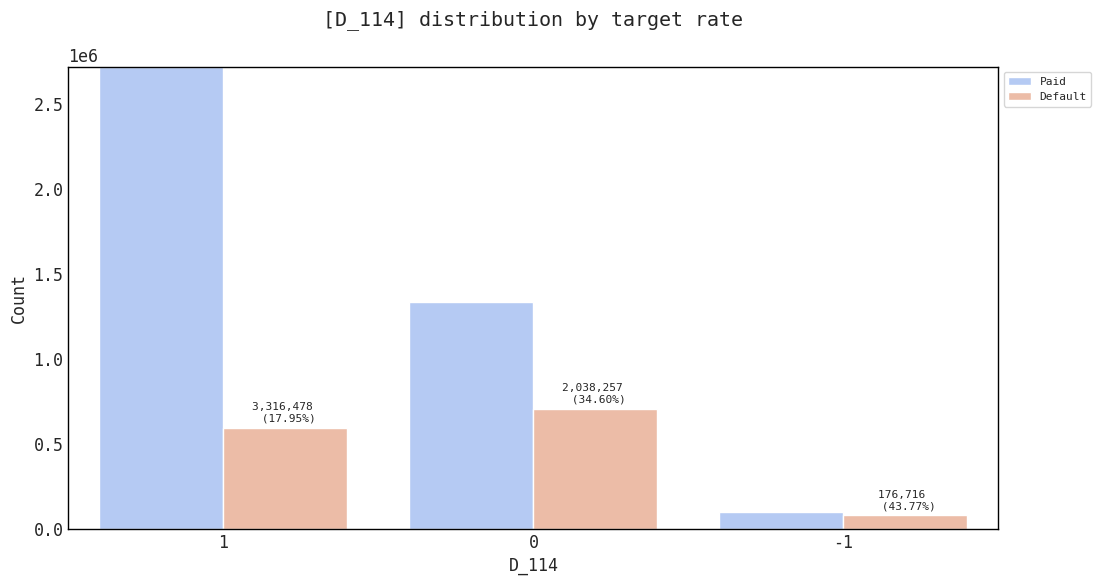

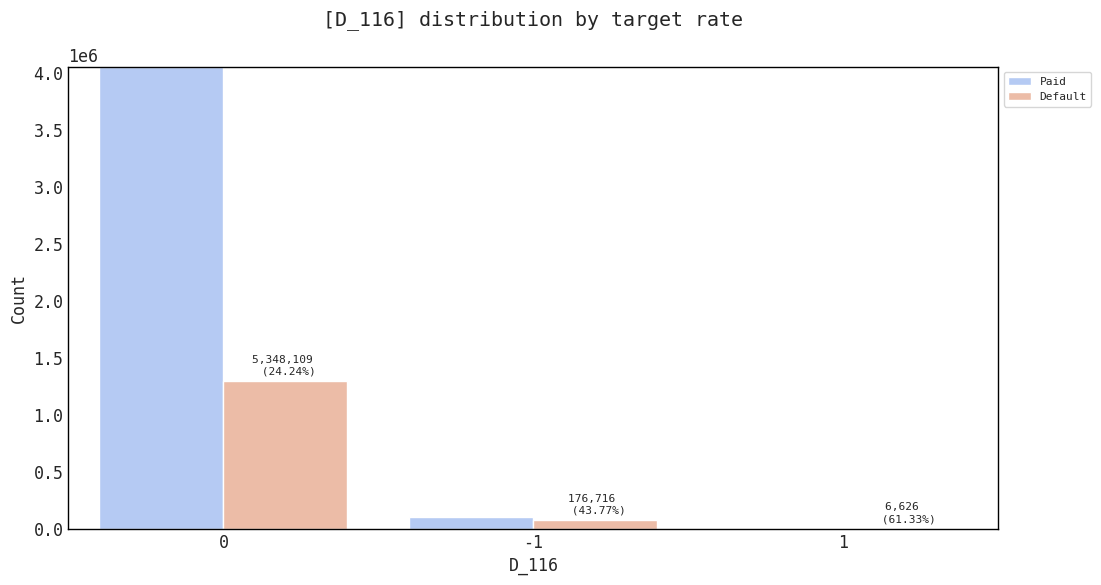

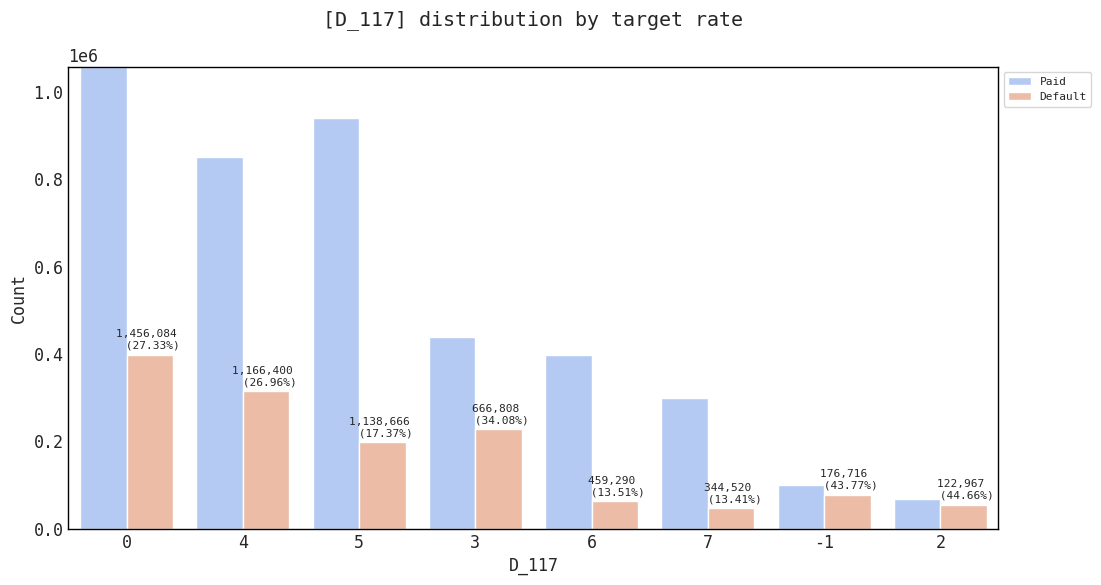

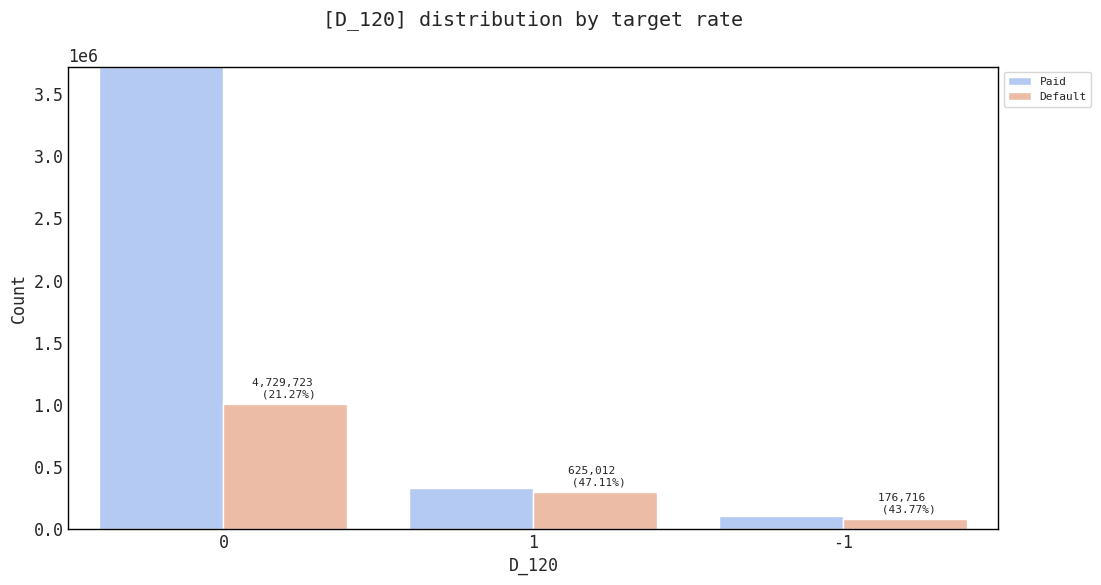

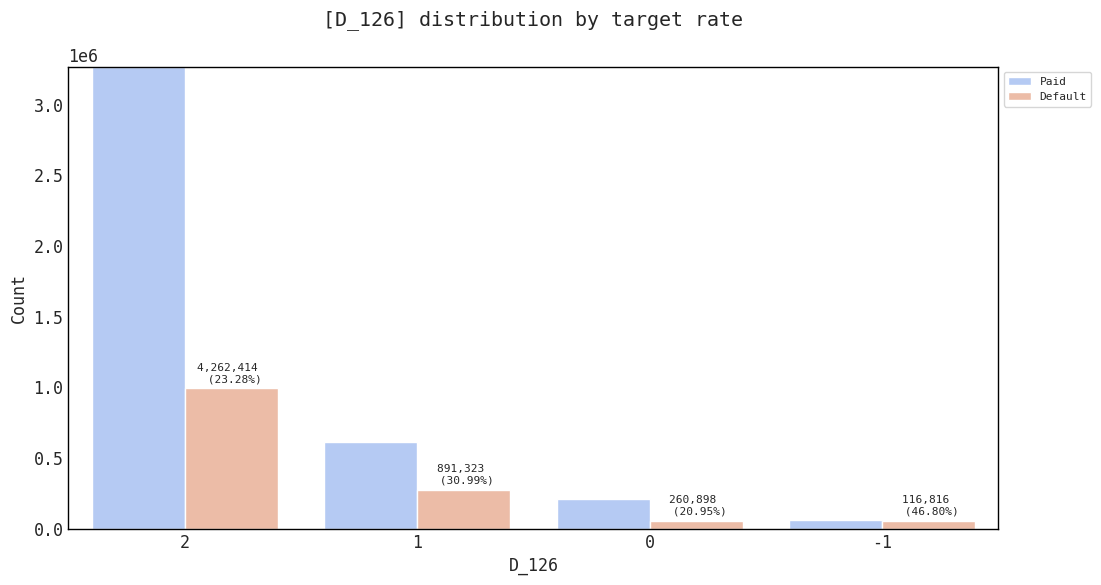

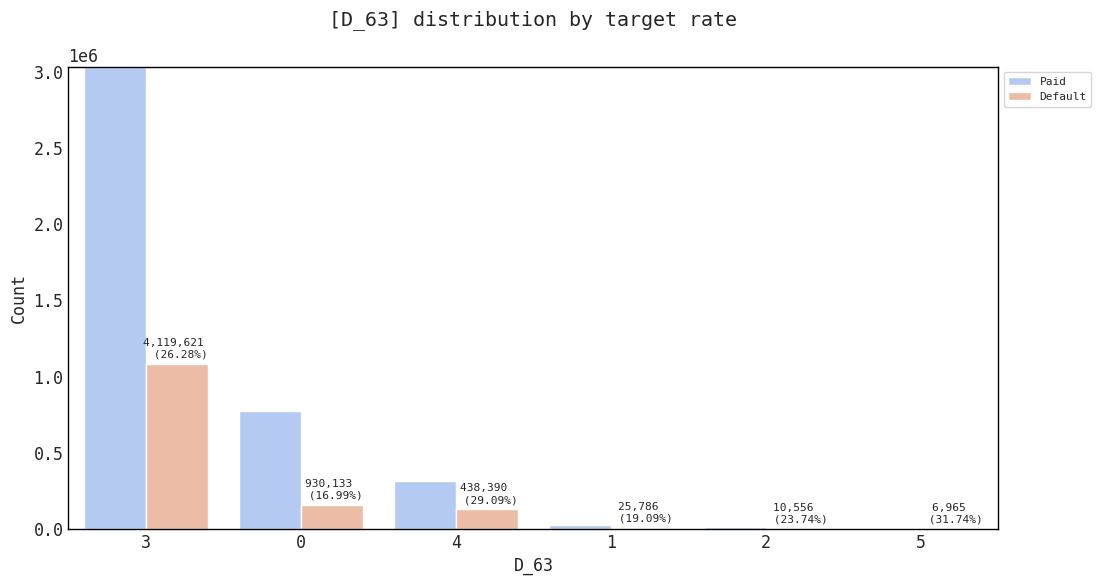

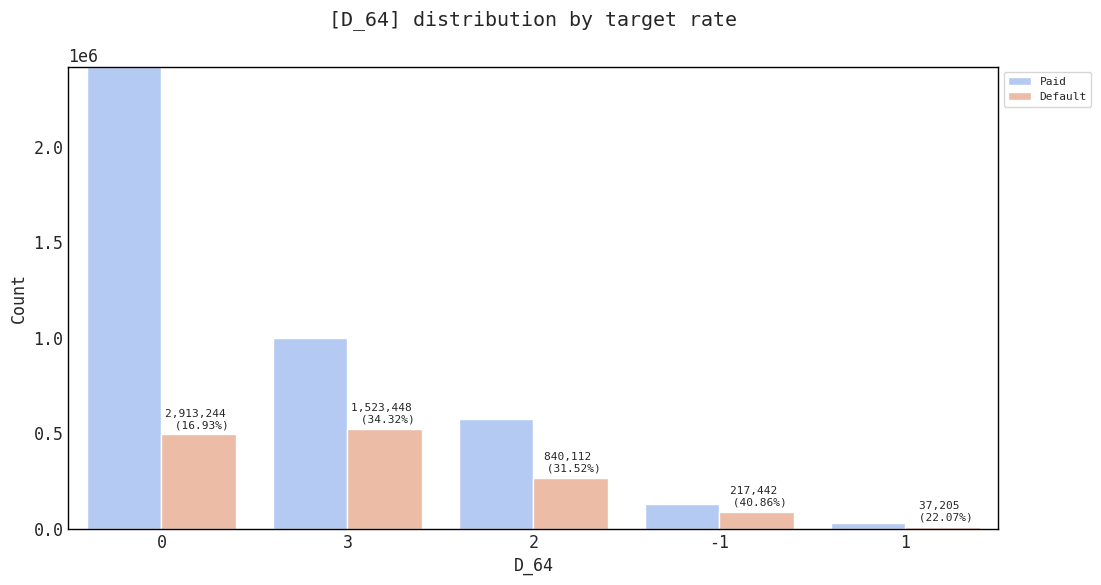

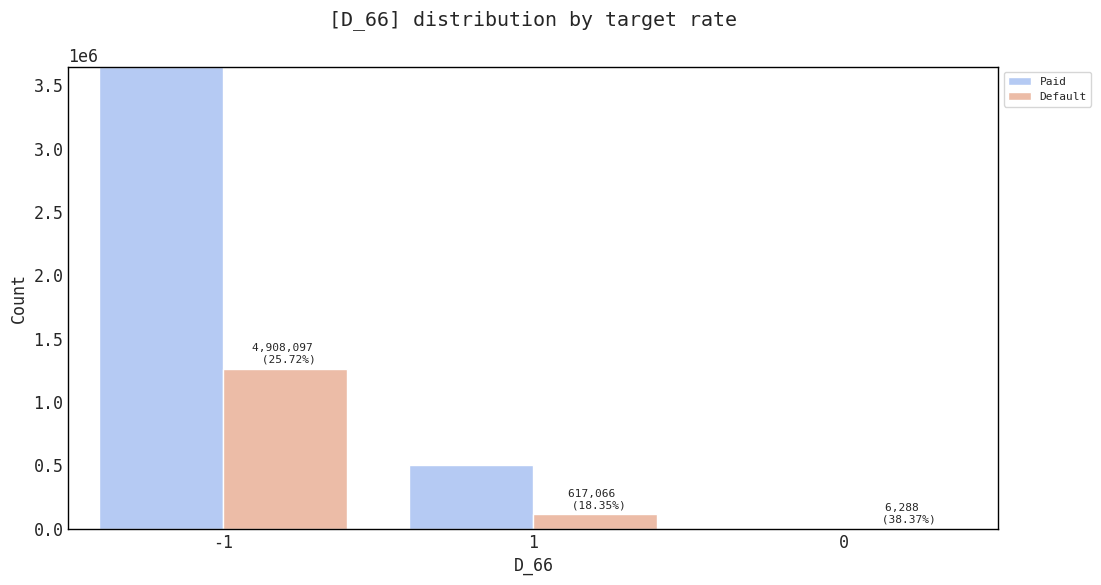

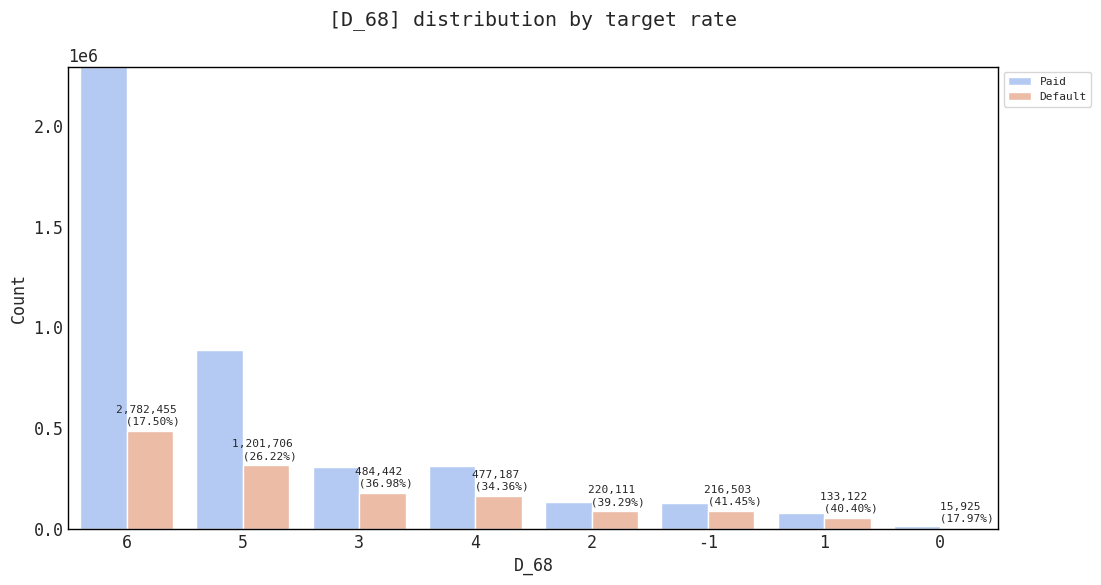

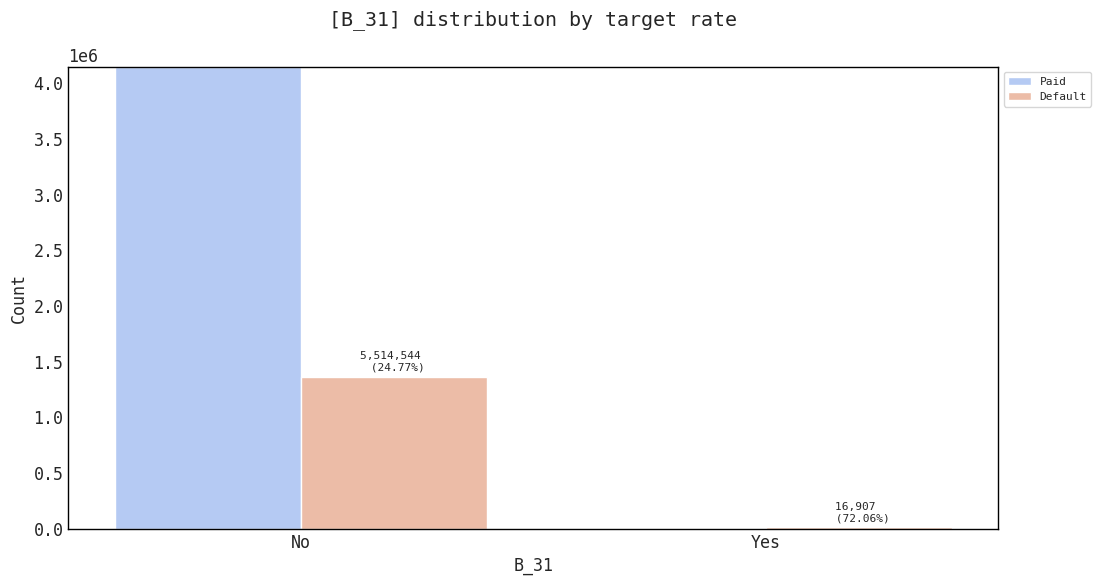

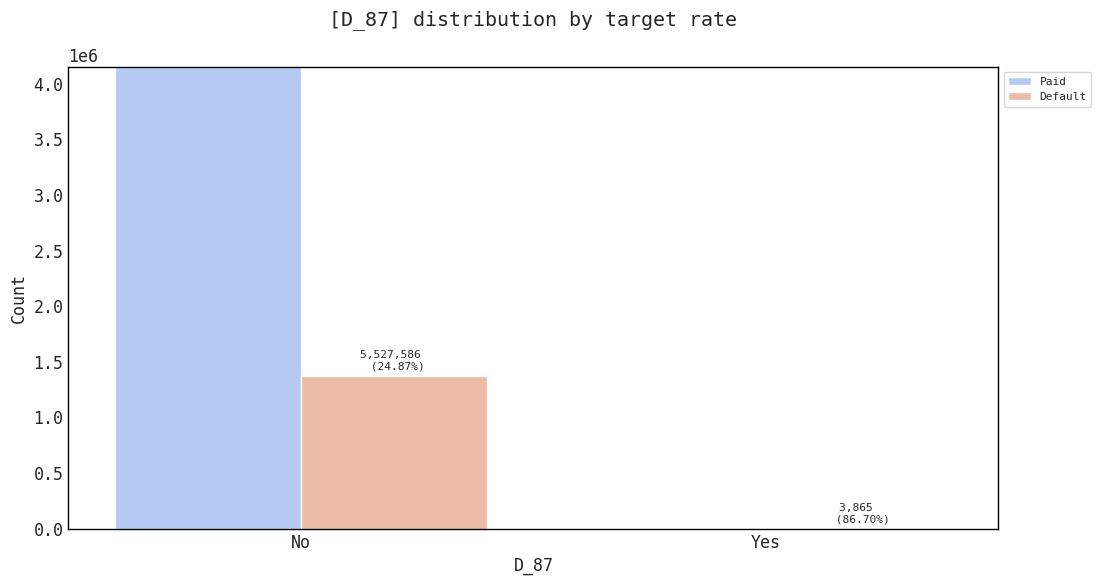

In [259]:
for fea in cat_features:
    plot_cate_by_label_rate(fea, train, rotate=0, order_use=None, hue_label='target', title=None, fontsize=8)


## 2.5 The numerical features

Out of the 175 numerical features, we picked 3 Payment variables and showcase their kernel density estimation plots comparison between the 'Paid' and 'Default'. Similar plots for other numerical features can be generated if needed.

**Insight**:

    - The kernel density for the "Default" and "Paid" groups shows an obvious discrepancy in their 'P_2'. One is highly skewed versus the other one being symmetric. 
    - Although the kernel densities in 'P_3' and 'P_4' have similar symmetry, the intergroup scale differences are pretty much noticeable. 

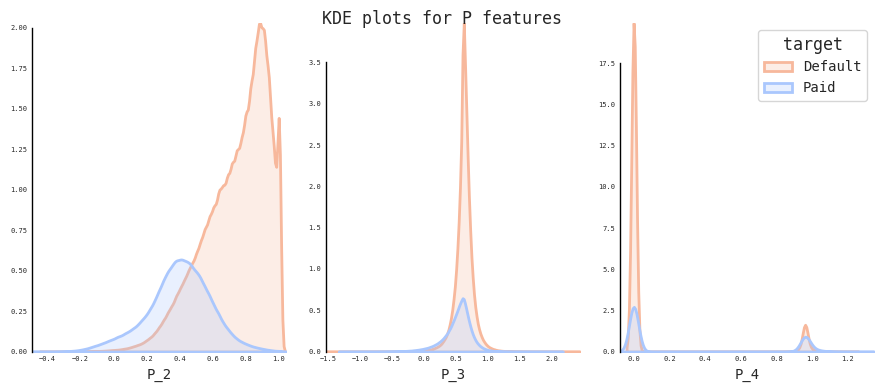

In [260]:
def show_kdeplots(letter, figsize, plot_column_count):   
    cols = [c for c in train.columns if (c.startswith((letter,'t'))) & (c not in cat_features)]
    df_tmp = train[cols]
    plt_cols = plot_column_count
    plt_rows = int(len(cols)/plt_cols)

    fig, axes = plt.subplots(plt_rows, plt_cols, figsize=figsize)
    for i, ax in enumerate(axes.reshape(-1)):
        if i<len(cols)-1:
            sns.kdeplot(x=cols[i], hue='target', hue_order=[1,0], label=['Default','Paid'], data=df_tmp, 
                        fill=True, linewidth=2, legend=False, ax=ax, palette='coolwarm')
        ax.tick_params(left=False, bottom=False, labelsize=5)
        ax.xaxis.get_label().set_fontsize(10)
        ax.set_ylabel('')

    sns.despine(bottom=True, trim=True)
    plt.tight_layout(rect=[0, 0.2, 1, 0.99])
    plt.suptitle(f'KDE plots for {letter} features', fontsize=12)
    plt.legend(title='target', loc='upper right', labels=['Default','Paid'], fontsize=10)
    plt.show()

show_kdeplots('P', (9, 5), 3)

# 3. Preprocessing

## 3.1 Standardization and Outliers

We standardized all of the numerical features for the sake of computation easiness. Outlier detection is omitted for now because they have almost no impact on tree-based models. 

**Insight**:

    - Given the bulk of our training models are tree-based, which are famous for its insensitivity to outliers, we team them up the StandardScalar. However, we can always switch to the MinMaxScalar if the StandardScalar did not render expected performance.  
    - Similarly, we always have the option to throw in outliers handling process if the outcome falls under of our expectation. 
    

In [261]:
# select the numerical features
num_features = [c for c in X_train.columns if (c not in ['customer_ID', 'S_2']) and (c not in cat_features)]

# use StandardScaler to scale all of the numerical features
scaler = preprocessing.StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

In [262]:
del train


## 3.2 Missing values

The dataset is rich of NA records. Especially it is very likely that we have both systemically missing NA and missing at random NA according to this [discussion](https://www.kaggle.com/code/raddar/understanding-na-values-in-amex-competition), which suggests feature-wise NA is ought to be treated discriminately when performing the the imputation and feature engineering.  

Some facts:
- 67 out of 189 features have missing values. 
- 17 features' missing rates exceed 50%. We will drop them for model simplicity.
- Through features B_29 and D_87, we can see that the missing pattern of the same feature varies between the training and testing set.
- 


**Insight:**

    - Is the missing caused by feature truncated? Most features are 16-bit floats. The original data (in the csv file) has higher precision. By rounding it to 16-bit precision, some information is lost, meaning only the first 3 digits after the decimal point are preserved.
    - The missing values are not missing at random. The missing values are related to the statement date. For example, the feature B_29 has missing values until May of 2019. Starting in June of 2019, we have B_29 data for almost every customer. This is a feature that we should be careful with.
    - The missing values are not missing at random. The missing values are related to the target. For example, the feature D_87 has missing values only for customers with target 0. This is a feature that we should be careful with. 
    - Need to choose the missing imputation methods, like KNN, RF, constant/statistic filler carefully.

In [58]:
X_train.describe()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,...,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
count,5531451,5485466.00,5531451.00,5531451.00,5529435.00,5531451.00,4510907.00,5529435.00,5529435.00,791314.00,3873055.00,5531451.00,...,194699.00,5531451.00,5531451.00,5531451.00,5531451.00,5531451.00,5531451.00,5429903.00,944408.00,5531451.00,5490724.00,5531451.00
mean,2017-09-20 21:47:03.013998080,0.66,5.04,0.12,0.62,0.08,0.23,0.06,0.13,0.18,0.15,0.81,...,0.33,-0.96,-0.93,-0.96,-0.95,0.15,0.01,0.16,0.39,0.15,0.05,0.60
min,2017-03-01 00:00:00,-0.46,0.00,-7.59,0.00,0.00,-0.63,0.00,0.00,-0.00,0.00,-1.00,...,-0.01,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,0.00,-0.01,-1.00,0.00,-1.00
25%,2017-06-15 00:00:00,0.48,0.00,0.01,0.11,0.00,0.13,0.00,0.01,0.04,0.04,0.00,...,0.11,-1.00,-1.00,-1.00,-1.00,0.00,0.00,0.00,0.20,0.00,0.00,0.00
50%,2017-09-23 00:00:00,0.69,0.00,0.03,0.81,0.01,0.16,0.00,0.01,0.12,0.09,0.00,...,0.22,-1.00,-1.00,-1.00,-1.00,0.00,0.00,0.00,0.38,0.00,0.01,0.00
75%,2017-12-29 00:00:00,0.86,8.00,0.13,1.00,0.01,0.26,0.00,0.16,0.25,0.18,1.00,...,0.45,-1.00,-1.00,-1.00,-1.00,0.00,0.00,0.00,0.56,0.00,0.01,0.00
max,2018-03-31 00:00:00,1.01,183.00,1.32,1.01,3.26,5.48,8.99,1.63,4.19,10.11,45.00,...,1.01,1.00,7.00,1.00,6.00,1.00,1.00,1.34,2.23,1.00,1.34,53.00
std,NaN,0.24,9.18,0.21,0.40,0.23,0.19,0.20,0.23,0.23,0.21,1.77,...,0.30,0.19,0.39,0.19,0.26,0.41,0.17,0.35,0.24,0.41,0.18,2.12


In [79]:
# show the percentage of missing values in the train data
missing = X_train.isnull().mean().sort_values(ascending=False).rename('missing %')
missing = missing[missing > 0]*100
missing.head(20)

D_88    99.89
D_110   99.43
B_39    99.39
D_73    98.99
B_42    98.71
D_134   96.48
B_29    93.10
D_132   90.19
D_76    88.75
D_42    85.69
D_142   82.93
D_53    73.84
D_50    56.81
B_17    56.72
D_105   54.62
D_56    54.07
S_9     53.04
D_77    45.45
D_43    29.98
S_27    25.33
Name: missing %, dtype: float64

In [86]:
fea_100_50_missing = missing[missing >= 50].index.to_list()
fea_100_50_missing

['D_88',
 'D_110',
 'B_39',
 'D_73',
 'B_42',
 'D_134',
 'B_29',
 'D_132',
 'D_76',
 'D_42',
 'D_142',
 'D_53',
 'D_50',
 'B_17',
 'D_105',
 'D_56',
 'S_9']

Now we'll look at the distribution of missing values over time. B_29 is most interesting. Given the each of the three datasets has almost half a million customers, we see that until May of 2019 fewer than a tenth of the customers have a value for B_29. The other nine tenths are missing. Starting in June of 2019, we have B_29 data for almost every customer.

**Insight:** 
    - The test data come from a different phase in the economic cycle than the training data. Our models have no way of learning the effect of the economic cycle.
    - The distribution of the missing B_29 differs between train and test datasets. Whereas in the training and public leaderboard data >90 % are missing, during the last five months of private leaderboard, we have B_29 data for almost every customer. If we use this feature, we should be prepared for surprises in the private leaderboard.

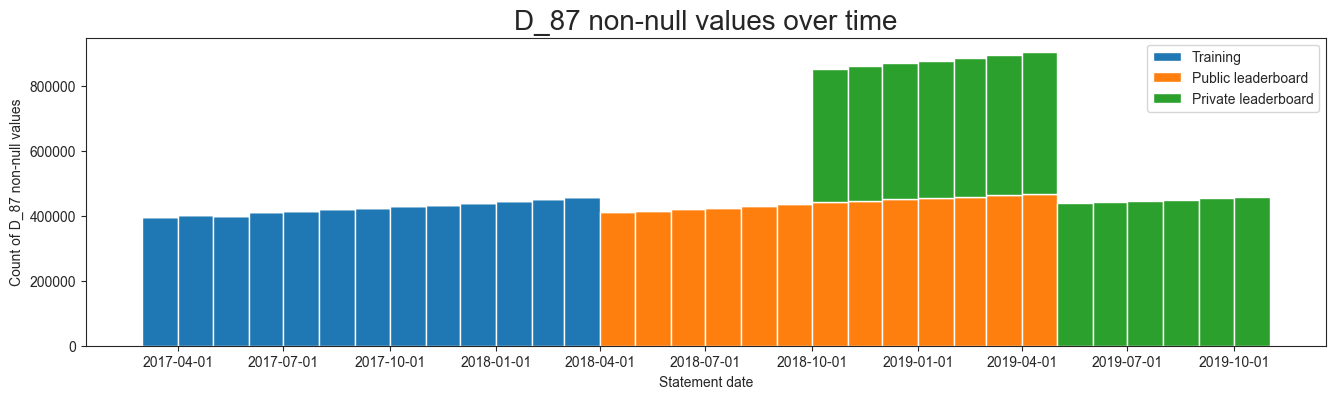

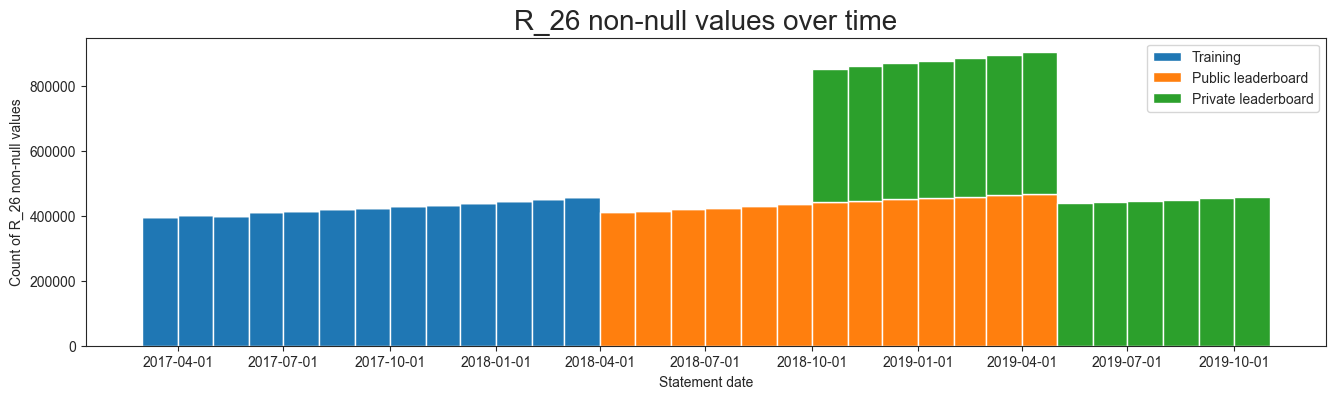

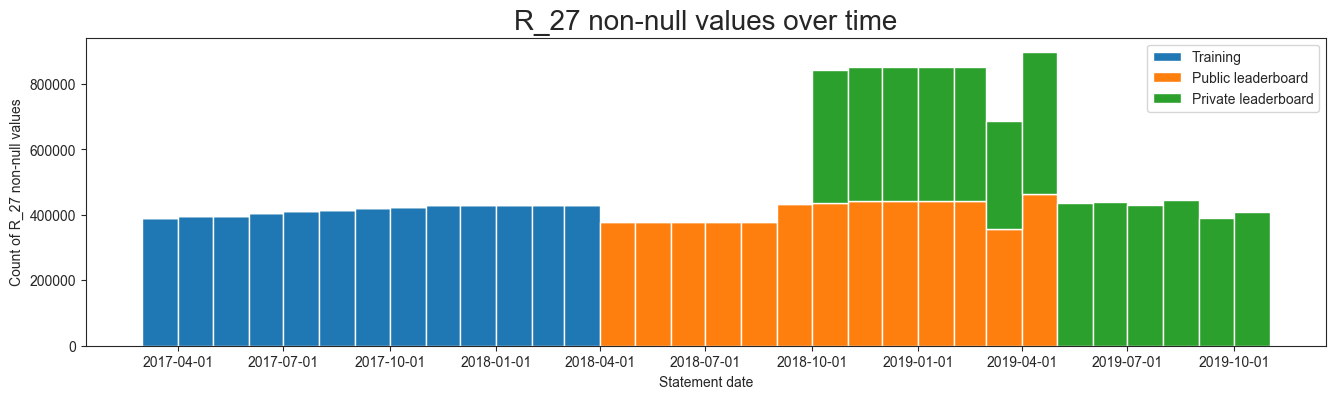

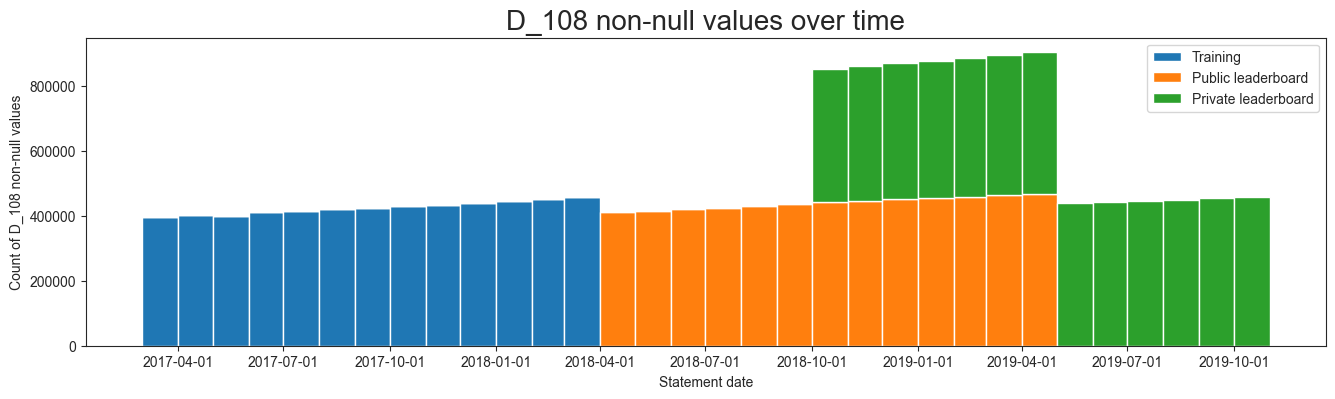

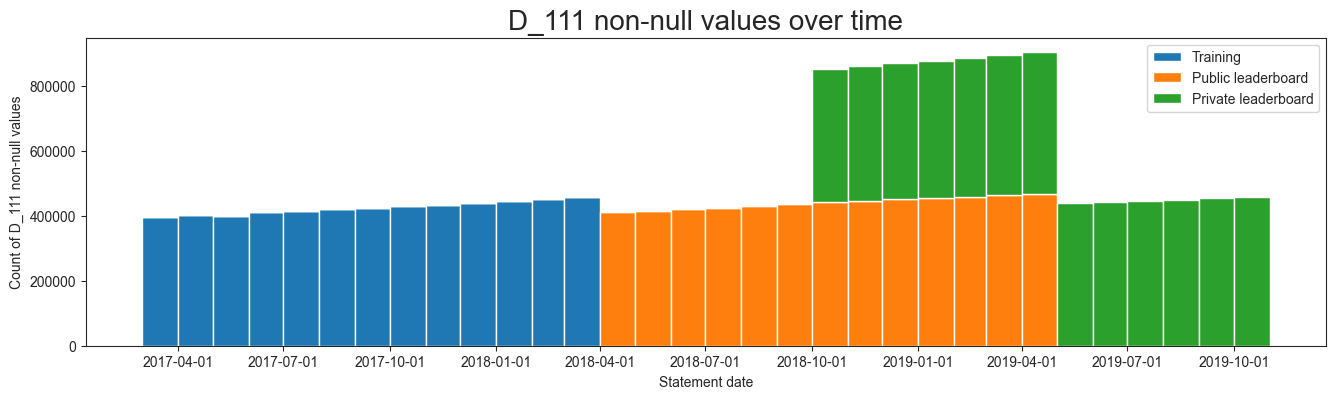

In [89]:
for f in [ 'B_29','D_87']:#, 'R_26', 'R_27', 'D_108', 'D_111', 'B_39', 'B_42']:
    temp = pd.concat([X_train[[f, 'S_2']], X_test[[f, 'S_2']]], axis=0)
    temp['last_month'] = last_month
    temp['has_f'] = ~temp[f].isna() 

    plt.figure(figsize=(16, 4))
    plt.hist([temp.S_2[temp.has_f & (temp.last_month == 3)],   # ending 03/18 -> training
              temp.S_2[temp.has_f & (temp.last_month == 4)],   # ending 04/19 -> public lb
              temp.S_2[temp.has_f & (temp.last_month == 10)]], # ending 10/19 -> private lb
             bins=pd.date_range("2017-03-01", "2019-11-01", freq="MS"),
         label=['train', 'test (public)', 'test (private)'],
             stacked=True)
    plt.xticks(pd.date_range("2017-03-01", "2019-11-01", freq="QS"))
    plt.xlabel('Statement date')
    plt.ylabel(f'Count of {f} non-null values')
    plt.title(f'{f} non-null values over time', fontsize=20)
    plt.legend()
    plt.show()
del temp

In [ ]:
# drop the features in fea_100_50_missing from the train and test data
X_train.drop(columns=fea_100_50_missing, inplace=True)
X_test.drop(columns=fea_100_50_missing, inplace=True)

The idea is to identify feature clusters having the same NA values for each row - that is what I will be focusing in this notebook onwards. Let's explore clusters having more than 4 features.

In [100]:
cols = sorted(X_train.columns[2:].tolist())
nas = X_train[cols].isna().sum(axis=0).reset_index(name='NA_count')
nas['group_count'] = nas.loc[nas.NA_count>0].groupby('NA_count').transform('count')
clusters = nas.loc[nas.group_count>4].sort_values(['NA_count','index']).groupby('NA_count')['index'].apply(list).values
clusters

array([list(['B_2', 'B_26', 'B_27', 'B_3', 'D_41', 'D_54']),
       list(['D_104', 'D_128', 'D_130', 'D_131', 'D_141'])], dtype=object)

There are 2 large clusters having many overlapping NA rows! Let's analyse each cluster!

In [94]:
cluster0_customers = set(X_train.loc[pd.isnull(X_train[clusters[0][0]]),'customer_ID'])
cluster1_customers = set(X_train.loc[pd.isnull(X_train[clusters[1][0]]),'customer_ID'])

cluster ZERO
Let's just simply look at how the customer profile looks for this feature cluster:m

In [96]:
X_train.loc[X_train.customer_ID.isin(cluster0_customers),['customer_ID','S_2']+clusters[0]].head(30)

,customer_ID,S_2,B_2,B_26,B_27,B_3,D_41,D_54
12883,-2838127185435729070,2017-11-06,NaN,NaN,NaN,NaN,NaN,NaN
12884,-2838127185435729070,2017-12-31,0.82,0.00,0.01,0.00,0.00,1.00
12885,-2838127185435729070,2018-01-05,0.07,0.00,0.01,0.03,0.00,1.00
12886,-2838127185435729070,2018-02-15,0.00,0.01,0.00,0.20,0.00,1.00
12887,-2838127185435729070,2018-03-03,0.01,0.01,0.01,0.28,0.00,1.00
15183,2204877969728340777,2017-03-09,NaN,NaN,NaN,NaN,NaN,NaN
15184,2204877969728340777,2017-04-29,0.81,0.00,0.01,0.01,0.00,1.00
15185,2204877969728340777,2017-05-08,0.10,0.00,0.01,0.03,0.00,1.00
15186,2204877969728340777,2017-06-07,0.11,0.01,0.01,0.04,0.00,1.00
15187,2204877969728340777,2017-07-08,0.10,0.01,0.01,0.04,0.00,1.00


In [99]:
# For the features in this cluster, how many customers have NA only show up in their first rows?
print('NA counts, only in first rows of the customer')
print(X_train.loc[X_train.customer_ID.isin(cluster0_customers)].groupby('customer_ID', observed=False)[clusters[0]].head(1).isna().sum(axis=0))

# For the features in this cluster, how many customers have NA only show up in all rows?
print('NA counts, in all rows of the customer')
print(X_train[clusters[0]].isna().sum(axis=0))

NA counts, only in first rows of the customer
B_2     2016
B_26    2016
B_27    2016
B_3     2016
D_41    2016
D_54    2016
dtype: int64
NA counts, in all rows of the customer
B_2     2016
B_26    2016
B_27    2016
B_3     2016
D_41    2016
D_54    2016
dtype: int64


Were you able to notice the pattern? What if I told you that NA appears only on the first observation for each customer! So for this feature cluster NA represents fresh credit card accounts with probably zero balance!

Q: How could I use this information?
We know that the dataset has varying number of available observations for each customer (N=1,...,13). It is only naturally obvious that 'last' type features are the strongest ones during model building. For N=1 observations things tend to get interesting, for those NAs devastate the 'last' type features, which may be quite a headache for non-GBDT models in particular. 
**Hence, it is now safe to impute the NAs amongs all features within this cluster to zeros. ** 